In [1]:
import numpy as np
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
g_datafolder = '/development/data'
g_customer_dataset = '{}/olist_customers_dataset.csv'.format(g_datafolder)
g_orders_dataset = '{}/olist_orders_dataset.csv'.format(g_datafolder)
g_payments_dataset = '{}/olist_order_payments_dataset.csv'.format(g_datafolder)
g_orderitems_dataset = '{}/olist_order_items_dataset.csv'.format(g_datafolder)


In [3]:
def load_dataset(datafile, parse_dates=None):
    df = pd.read_csv(datafile, delimiter=',', parse_dates=parse_dates)
    return df

In [4]:
customer_df = load_dataset(g_customer_dataset)
parse_dates = ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders_df = load_dataset(g_orders_dataset, parse_dates=parse_dates)
payments_df = load_dataset(g_payments_dataset)
orderitems_df = load_dataset(g_orderitems_dataset)
cust_ord_df = orders_df.set_index('customer_id').join(customer_df.set_index('customer_id'), how="inner").reset_index()
cust_ord_df = cust_ord_df.set_index('order_id').join(orderitems_df.set_index('order_id'), how="inner").reset_index()
cust_ord_df['total_value'] = np.round(cust_ord_df['price'] + cust_ord_df['freight_value'], 0)

In [5]:
observation_period_end = cust_ord_df.order_purchase_timestamp.max()
calibration_period_end = datetime(2018,4,1)
data_df = calibration_and_holdout_data(cust_ord_df
                                    , customer_id_col='customer_unique_id'
                                    , datetime_col='order_purchase_timestamp'
                                    , calibration_period_end=calibration_period_end
                                    , observation_period_end=observation_period_end
                                    , monetary_value_col='total_value')

In [6]:
data_df[data_df.recency_cal > 0.0].head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,248.0,103.0,0.0,0.0,155
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,41.0,96.0,0.0,0.0,155
011b4adcd54683b480c4d841250a987f,1.0,177.0,222.0,150.0,0.0,0.0,155
013f4353d26bb05dc6652f1269458d8d,1.0,4.0,128.0,164.0,0.0,0.0,155
015557c9912277312b9073947804a7ba,1.0,39.0,374.0,73.0,0.0,0.0,155


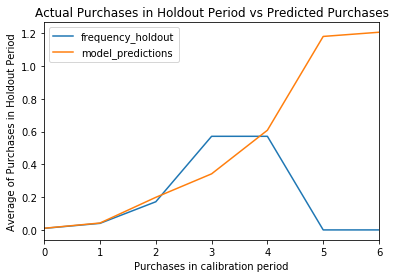

In [7]:
#Fader, Peter S., Bruce G.S. Hardie, and Ka Lok Lee (2005a), “Counting Your Customers the Easy Way: An Alternative to the Pareto/NBD Model,” Marketing Science, 24 (2), 275-84.   
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data_df['frequency_cal'], data_df['recency_cal'], data_df['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, data_df)

In [8]:
predicted_df = bgf.conditional_expected_number_of_purchases_up_to_time(t=155
                                                       ,frequency=data_df['frequency_cal']
                                                       ,recency=data_df['recency_cal']
                                                       ,T=data_df['T_cal'])
data_df['frequency_predicted'] = predicted_df

In [9]:
palive_df = bgf.conditional_probability_alive(frequency=data_df['frequency_cal']
                                             ,recency=data_df['recency_cal']
                                             ,T=data_df['T_cal'])
data_df['p_alive'] = palive_df

In [11]:
data_df['is_ignore'] = 1
data_df = data_df.reset_index()

In [12]:
data_df[['frequency_cal', 'frequency_holdout', 'frequency_predicted', 'is_ignore']] \
       .groupby(['frequency_cal']) \
       .agg({'frequency_holdout':'mean', 'frequency_predicted':'mean', 'frequency_holdout':'mean', 'is_ignore':'sum'})


,frequency_holdout,frequency_predicted,is_ignore
frequency_cal,,,
0.0,0.009553,0.010218,62703
1.0,0.040109,0.042139,1097
2.0,0.171875,0.198918,64
3.0,0.571429,0.342309,7
4.0,0.571429,0.608536,7
5.0,0.000000,1.181121,1
6.0,0.000000,1.206688,1
8.0,7.000000,0.355354,1


In [13]:
np.mean(np.abs(data_df.frequency_holdout - data_df.frequency_predicted))


0.021142395166281622

In [23]:
data_df.count()

customer_unique_id        63881
frequency_cal             63881
recency_cal               63881
T_cal                     63881
monetary_value_cal        63881
frequency_holdout         63881
monetary_value_holdout    63881
duration_holdout          63881
frequency_predicted       63881
p_alive                   63881
is_ignore                 63881
dtype: int64

In [14]:
cols = ["frequency_cal", "recency_cal", "T_cal", "frequency_holdout","duration_holdout","frequency_predicted", "p_alive"]
#df[df.x_cal == 2][cols].head(n=100)
data_df[data_df.customer_unique_id.isin(['a12a52a129241056f2224794d70774ee','f2ba66a2a2704983864ee770bb9afdb6'])][cols]


,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency_predicted,p_alive
40256,0.0,0.0,262.0,0.0,155,0.006582,1.0
60601,0.0,0.0,376.0,0.0,155,0.005094,1.0


/opt/conda/lib/python3.7/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


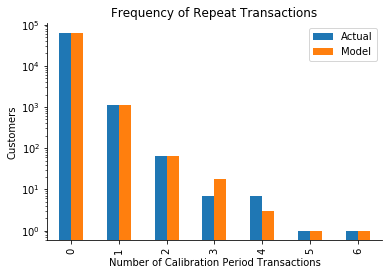

In [16]:
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

In [17]:
data_df[['monetary_value_cal', 'frequency_cal']].corr()


,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.618717
frequency_cal,0.618717,1.000000


In [18]:
## Technically there is a high correlation between the monetary_value and frequency, so we should not use the GammaGamma model
## Below code is for demonstration purpose

In [19]:
ggf = GammaGammaFitter(penalizer_coef = 0)
data2_df = data_df[data_df.frequency_cal > 0.0]
ggf.fit(data2_df['frequency_cal'], data2_df['monetary_value_cal'])
profit_df = ggf.conditional_expected_average_profit(data2_df['frequency_cal'], data2_df['monetary_value_cal'])
clv_df = ggf.customer_lifetime_value(bgf, time=12
                                     ,frequency=data2_df['frequency_cal']
                                     ,recency=data2_df['recency_cal']
                                     ,T=data2_df['T_cal']
                                     ,monetary_value =data2_df['monetary_value_cal'])

In [22]:
data2_df.count()

customer_unique_id        1178
frequency_cal             1178
recency_cal               1178
T_cal                     1178
monetary_value_cal        1178
frequency_holdout         1178
monetary_value_holdout    1178
duration_holdout          1178
frequency_predicted       1178
p_alive                   1178
is_ignore                 1178
dtype: int64